# QSVM on MNIST

In [1]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split

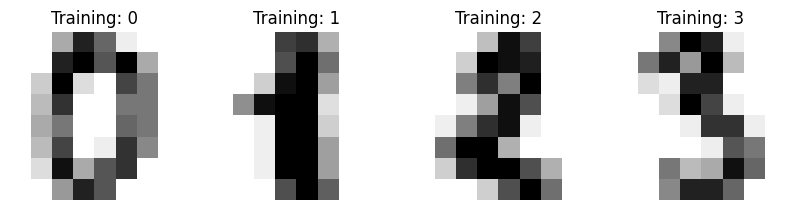

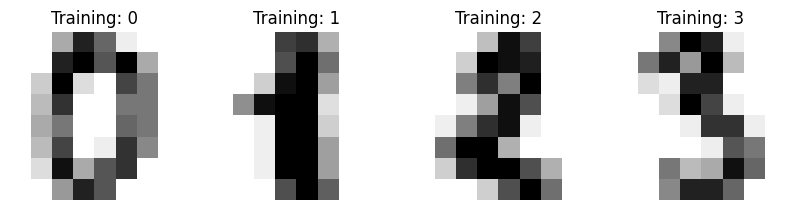

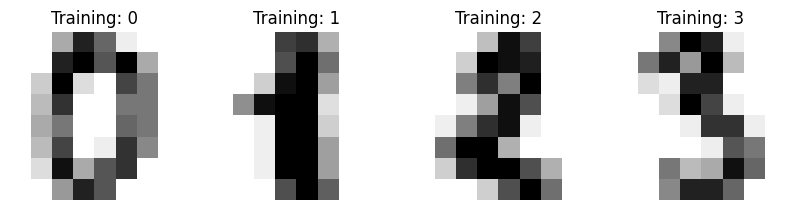

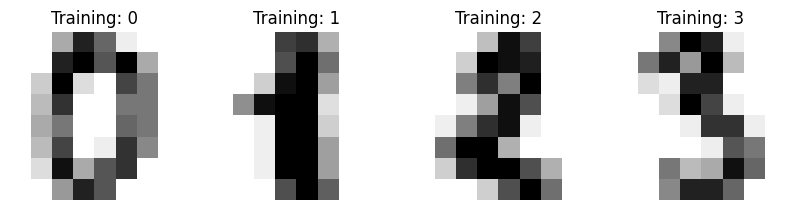

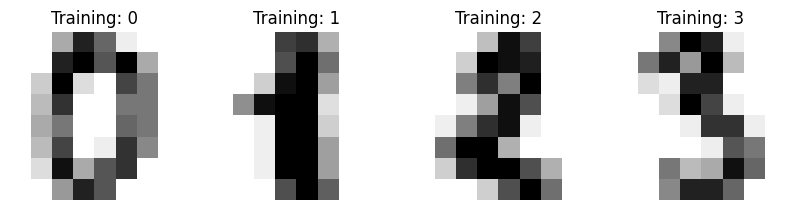

In [9]:
%matplotlib inline
digits = datasets.load_digits()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Training: {label}")

plt.show()

In [8]:
print(len(digits.images))

1797
